TODOs:
- make the creation of patches more intelligent --> less patches, e.g. only use very small patches in image regions where cars will be far away

In [1]:
import numpy as np 
import glob
import cv2

def plot_image(img, title=None, size=(8,5)):
    plt.figure(figsize=size)
    plt.axis("off")
    
    if title is not None:
        plt.title(title)
        
    if len(img.shape) == 3:
        plt_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(plt_image)
    else:
        plt.imshow(img, cmap='gray')        

    plt.show()

def read_images(image_dir_list):    
    images = []
    
    for img_dir in image_dir_list:    
        
        if 'GTI' in img_dir:
            mod_counter = 1 # load only every 5th image             
        else: 
            mod_counter = 1
    
        # get all image files in the current directory
        img_file_list = glob.glob('./training_data/' + img_dir + '/?*.png')
        
        img_counter = 0
        
        for img_file in img_file_list:
            img_counter += 1
            if img_counter % mod_counter == 0:
                img = cv2.imread(img_file)        
                images.append(img)              
    
    print('imported {} images'.format(len(images)))  
            
    return images         

In [2]:
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

pix_per_cell = 8

def get_hog_feature_map(img):

    cell_per_block = 2
    num_orientations = 9     

    features = hog(img, orientations=num_orientations, pixels_per_cell=(pix_per_cell, pix_per_cell), 
                   cells_per_block=(cell_per_block, cell_per_block), block_norm='L2-Hys',
                   visualise=False, feature_vector=False)
    
    return features

def get_hog_feature_vec(img):

    cell_per_block = 2
    num_orientations = 9     

    feature_vec = hog(img, orientations=num_orientations, pixels_per_cell=(pix_per_cell, pix_per_cell), 
                      cells_per_block=(cell_per_block, cell_per_block), block_norm='L2-Hys',
                      visualise=False, feature_vector=True)

    return feature_vec

def plot_feature_vec(feature_vec):
    plt.bar(np.arange(0, len(feature_vec)), feature_vec)
    plt.show()
    
def normalize_vec(feature_vec):
    # Reshape the vector
    vector = feature_vec.reshape(-1, 1)
    # Create the scaler for normalization
    scaler = StandardScaler().fit(vector)
    # Apply the scaler 
    scaled_vec = scaler.transform(vector)
    
    return scaled_vec
        
def convert_to_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def get_hist_feature_vec_single_channel(img):
    
    n_cells = 3 # number of square cells the image gets divided into (along each axis) 
    n_bins = 10 # number of histogram bins
    
    # using two few bins leads to more false positives (e.g. 3 cells, 5 bins)
    # 10 bins seems to be a good compromise
    # using 
    
    size = img.shape[0]    
    feature_vec = np.zeros((n_cells*n_cells*n_bins))
    
    for ix in range(n_cells):
        for iy in range(n_cells):
            
            start_y = int(iy*size*1.0/n_cells)
            end_y = int((iy+1)*size*1.0/n_cells)
            
            start_x = int(ix*size*1.0/n_cells)
            end_x = int((ix+1)*size*1.0/n_cells)
            
            hist, bins = np.histogram(img[start_y:end_y, start_x:end_x], n_bins, (0, 256))
            
            feature_vec[(ix+iy)*n_bins:(ix+iy+1)*n_bins] = hist
    
    return feature_vec 

def get_hist_feature_vec(img):    

    #img_conv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) # worse
    img_conv = cv2.cvtColor(img, cv2.COLOR_BGR2HLS) 

    feature_vec_c0 = get_hist_feature_vec_single_channel(img_conv[:,:,0])
    feature_vec_c1 = get_hist_feature_vec_single_channel(img_conv[:,:,1])
    feature_vec_c2 = get_hist_feature_vec_single_channel(img_conv[:,:,2])

    hist_feature_vec = np.concatenate((feature_vec_c0, feature_vec_c1, feature_vec_c2))
  
    return hist_feature_vec
   
    
# def get_hist_feature_map(img): # TODO
#     #n_cells = 4
#     pix_per_cell = 8
#     n_bins = 10
    
#     # split image into 8px by 8px cells and calculate color histogram data for every cell
#     num_cells_dim1 = int(img.shape[0]/pix_per_cell)
#     num_cells_dim2 = int(img.shape[1]/pix_per_cell)
    
#     hist_map = np.zeros((num_cells_dim1, num_cells_dim2, 3, n_bins))
    
#     for i in range(num_cells_dim1):
#         for k in range(num_cells_dim2):
#             for n in range(3):                
#                 hist, bins = np.histogram(img[i*pix_per_cell:(i+1)*pix_per_cell-1,
#                                               k*pix_per_cell:(k+1)*pix_per_cell-1, n].ravel(), n_bins, (0, 256))
            
#                 hist_map[i, k, n, :] = hist.ravel()

    
#     return hist_map 
    
    
    
def extract_features(images):
    features = []
    
    for img in images:        
        hist_feature_vec = get_hist_feature_vec(img)
        
        img_gray = convert_to_gray(img)
        hog_feature_vec = get_hog_feature_vec(img_gray)   
        
        feature_vec_combined = np.concatenate((hist_feature_vec, hog_feature_vec))

        features.append(normalize_vec(feature_vec_combined))
        
    return features


In [3]:
from sklearn import svm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
import pickle

def calculate_test_accuracy(classifier, features, labels):   
    
    pred = classifier.predict(features)
    num_correct = np.count_nonzero(pred == labels)
    acc = 1.0*num_correct/len(labels)
            
    return acc            

def create_classifier(vehicle_features, non_vehicle_features):

    # create input data 'X' from features
    X = np.vstack((vehicle_features, non_vehicle_features))
    X = X.reshape((X.shape[0], X.shape[1]))

    # create output labels 'y': 1=vehicle, 0=non-vehicle
    vehicle_labels = np.ones((len(vehicle_features)))
    non_vehicle_labels = np.zeros((len(non_vehicle_features)))
    y = np.hstack((vehicle_labels, non_vehicle_labels))

    # shuffle the data
    X, y = shuffle(X, y)

    # split data into training and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # train a SVM for classification by performing a grid search in parameter space
    #parameters = {'kernel':('linear', 'rbf'), 'C':[1, 3, 5, 7, 9]} # best until now: {'C': 5, 'kernel': 'rbf'}
    parameters = {'C':[2]}
    svc = svm.SVC(kernel='linear')
    classifier = GridSearchCV(svc, parameters)
    
    print('begin training ...')
    
    classifier.fit(X_train, y_train)  
    
    print('finished training')    
    print('best parameters: {}'.format(classifier.best_params_)) # {'C': 5, 'kernel': 'rbf'}
    
    acc = calculate_test_accuracy(classifier, X_test, y_test)
    
    print('test accuracy = {:.3f}'.format(acc))
    
    # save the classifier
    with open('classifier.pkl', 'wb') as fid:
        pickle.dump(classifier, fid)  
        print('saved classifier')
    
    return classifier


C:\Users\Tobias\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Tobias\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [ ]:
train_classifier = True

if train_classifier: # train a new classifier 

    # read vehicle images
    vehicle_images = read_images(['vehicles/GTI_Far', 'vehicles/GTI_Left', 'vehicles/GTI_MiddleClose', 
                    'vehicles/GTI_Right', 'vehicles/KITTI_extracted'])
    #vehicle_images = read_images(['vehicles/KITTI_extracted'])
    
    # read non-vehicle images
    non_vehicle_images = read_images(['non-vehicles/GTI', 'non-vehicles/Extras'])
    #non_vehicle_images = read_images(['non-vehicles/Extras'])
    
    # extract features from images
    vehicle_features = extract_features(vehicle_images)  
    non_vehicle_features = extract_features(non_vehicle_images)  
    
    # train the classifier
    classifier = create_classifier(vehicle_features, non_vehicle_features) 
    #best parameters: {'C': 3}
    #test accuracy = 0.968
    
else: # open a saved classifier
    
    with open('classifier.pkl', 'rb') as fid:
        classifier = pickle.load(fid)   
        print('loaded classifier')


imported 8792 images
imported 8968 images


In [201]:

# def get_divisible_range(max_value, crop_percentage, divider):
    
#     start = int(max_value*crop_percentage[0])
#     end = int(max_value*crop_percentage[1])
    
#     delta = end - start     
#     delta = delta - (delta % divider)
    
#     end = start + delta
    
#     return start, end
    

# def crop_image(img): #crop the image in a way that the height and width is divisible by 'pix_per_cell'
    
#     y_crop_percentage = [0.5, 1.0]
#     x_crop_percentage = [0.0, 1.0]
    
#     y_start, y_end = get_divisible_range(img.shape[0], y_crop_percentage, pix_per_cell)
#     x_start, x_end = get_divisible_range(img.shape[1], x_crop_percentage, pix_per_cell)
    
#     img_cropped = img[y_start:y_end, x_start:x_end]
    
#     return img_cropped

def draw_patches(img_input, patches):
    
    img = np.copy(img_input)
    
    for patch in patches:
        img = cv2.rectangle(img, (patch[0], patch[1]), (patch[2], patch[3]), (0,255,0), 2)
        
    return img
 

def get_patches(img, stride):
    
    cells_per_patch = 8 # same number as for training the classifier
    num_hist_cells = 3
    
    stride_x = stride # stride of 4 = 50% overlap
    stride_y = stride # stride of 4 = 50% overlap
    
    start_x = 0
    start_y = 0
    
    end_x = img.shape[1]
    end_y = img.shape[0]
    
    img_patches = []
    hog_patches = []   
    hist_patches = []

    px = start_x
    py = start_y       

    qx = px + pix_per_cell*cells_per_patch 
    qy = py + pix_per_cell*cells_per_patch 

    while qx < end_x:           

        while qy < end_y:

            img_patches.append((px, py, qx, qy)) 
            hog_patches.append((int(1.0*px/cells_per_patch), 
                                int(1.0*py/cells_per_patch), 
                                int(1.0*qx/cells_per_patch), 
                                int(1.0*qy/cells_per_patch)))
            hist_patches.append((int(1.0*px/num_hist_cells), 
                                int(1.0*py/num_hist_cells), 
                                int(1.0*qx/num_hist_cells), 
                                int(1.0*qy/num_hist_cells)))
         

            py += stride_y*pix_per_cell                
            qy = py + pix_per_cell*cells_per_patch 

        px += stride_x*pix_per_cell
        qx = px + pix_per_cell*cells_per_patch   

        py = start_y   
        qy = py + pix_per_cell*cells_per_patch         
            
    return img_patches, hog_patches   

class DetectionLevel:
    def __init__(self, x_range, y_range, scaling_factor, stride):
        self.x_range = x_range
        self.y_range = y_range
        self.scaling_factor = scaling_factor
        self.stride = stride
        
        # corner points of the scaled image in the original image
        self.p1 = None
        self.p2 = None
        
        #self._init_patches()
        
    #def _init_patches():        
        
    def resize_image(self, img):        
        size_x = img.shape[1]
        size_y = img.shape[0]
        
        self.p1 = (int(self.x_range[0]*size_x), int(self.y_range[0]*size_y))
        self.p2 = (int(self.x_range[1]*size_x), int(self.y_range[1]*size_y))
        
        return cv2.resize(img[self.p1[1]:self.p2[1], self.p1[0]:self.p2[0]],                           
                          None, fx=self.scaling_factor, fy=self.scaling_factor, interpolation=cv2.INTER_AREA)
    

detection_levels = []
detection_levels.append(DetectionLevel((0.25, 0.75), (0.55, 0.7), 1.0, 2))
detection_levels.append(DetectionLevel((0.2, 0.8), (0.55, 0.7), 0.9, 2))
detection_levels.append(DetectionLevel((0, 1), (0.5, 0.7), 0.8, 2))
detection_levels.append(DetectionLevel((0, 1), (0.5, 0.7), 0.6, 2))
detection_levels.append(DetectionLevel((0, 1), (0.5, 0.8), 0.5, 2))
detection_levels.append(DetectionLevel((0, 1), (0.45, 0.8), 0.4, 2))
detection_levels.append(DetectionLevel((0, 1), (0.4, 0.8), 0.3, 2))
detection_levels.append(DetectionLevel((0, 1), (0.3, 1), 0.2, 2))


def get_sliding_window_features(img_orig):

    #if heat_map is None:
    heat_map = np.zeros((img_orig.shape[0], img_orig.shape[1]))    

    for level in detection_levels:
        
        img = level.resize_image(img_orig)  
        #plot_image(img)
        
        #hist_feature_vec = get_hist_feature_vec(img)
        #hist_feature_vec_norm = normalize_vec(hist_feature_vec) 
            
        img_gray = convert_to_gray(img)
        hog_map = get_hog_feature_map(img_gray)
        
        #hist_map = get_hist_feature_map(img)
        #print(hist_map.shape)

        img_patches, hog_patches = get_patches(img, level.stride)   
        #plot_image(draw_patches(img, img_patches))
        
        #hist_feature_vec = np.zeros((480))
            
        for img_patch, hog_patch in zip(img_patches, hog_patches):

            current_image = img[img_patch[1]:img_patch[3], img_patch[0]:img_patch[2]]               
            
            hist_feature_vec = get_hist_feature_vec(current_image)            
            
            #hist_feature_vec_norm = normalize_vec(hist_feature_vec)              
            hog_feature_vec = hog_map[hog_patch[1]:hog_patch[3]-1, hog_patch[0]:hog_patch[2]-1].ravel()

            
            #hog_feature_vec_norm = normalize_vec(current_hog_vec)
            feature_vec_combined = normalize_vec(np.concatenate((hist_feature_vec, hog_feature_vec)))
            #feature_vec_combined = normalize_vec(np.concatenate((hist_feature_vec, hog_vec_0, hog_vec_1, hog_vec_2)))
            
            pred = int(classifier.predict(feature_vec_combined.reshape(1, -1)))
            
            if pred == 1:
                #print('vehicle detected, scaling_factor = {}'.format(level.scaling_factor))
                
                #plot_image(current_image)
                
                x1 = level.p1[0] + int(img_patch[0]/level.scaling_factor)
                x2 = level.p1[0] + int(img_patch[2]/level.scaling_factor)
                
                y1 = level.p1[1] + int(img_patch[1]/level.scaling_factor)
                y2 = level.p1[1] + int(img_patch[3]/level.scaling_factor)

                heat_map[y1:y2, x1:x2] += 1


    return heat_map
          

In [202]:
import time

#img = cv2.imread('./test_images/test6.jpg')
img = cv2.imread('./export.jpg')

t_start = time.clock()
heat_map = get_sliding_window_features(img)
print(time.clock()-t_start)


3.2124186074070167


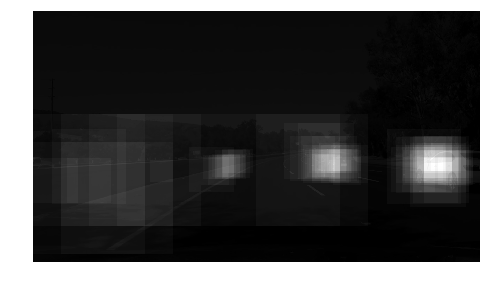

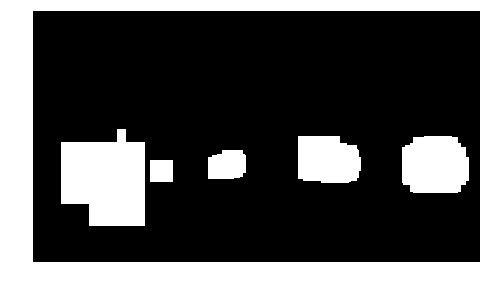

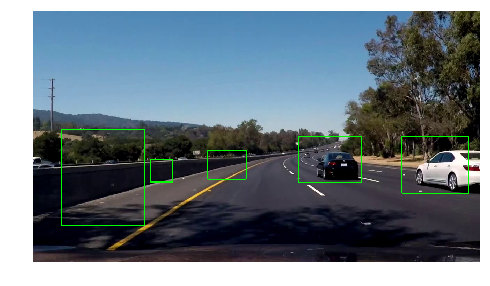

In [203]:
from scipy.ndimage.measurements import label

def draw_rectangle(img, p1, p2):
    return cv2.rectangle(img, p1, p2, (0,255,0), 2)

img_gray = convert_to_gray(img)
res = cv2.addWeighted(img_gray.astype('float64'), 0.8, heat_map, 80.0, 0)

plot_image(res)


heat_map_thresh = np.zeros_like(heat_map)
heat_map_thresh[heat_map >= 5] = 1

plot_image(heat_map_thresh)


labeled_array, num_features = label(heat_map_thresh)

for i in range(num_features):
    x_ind, y_ind = np.nonzero(labeled_array == i+1)
    #x_min = np.min(x_ind)
    #y_min = np.min(y_ind)
    #print(x_min, y_min)
    draw_rectangle(img, (np.min(y_ind), np.min(x_ind)), (np.max(y_ind), np.max(x_ind)))

plot_image(img)




In [ ]:
vidcap = cv2.VideoCapture('project_video.mp4')



#debug_mode = False

heat_map_buffer = []
def filter_heat_map(heat_map, buffer_size = 4):
    global heat_map_buffer

    if len(heat_map_buffer) < buffer_size:
        heat_map_buffer.append(heat_map)
    else:
        del heat_map_buffer[0]
        heat_map_buffer.append(heat_map)
        
    filtered_map = np.zeros_like(heat_map)
    
    for hm in heat_map_buffer:
        filtered_map += hm
        
    return filtered_map

def draw_vehicle_regions(img, heat_map, heat_threshold = 50):
    
    heat_map_thresh = np.zeros_like(heat_map)
    heat_map_thresh[heat_map >= heat_threshold] = 1

    labeled_array, num_features = label(heat_map_thresh)

    for i in range(num_features):
        x_ind, y_ind = np.nonzero(labeled_array == i+1)
        draw_rectangle(img, (np.min(y_ind), np.min(x_ind)), (np.max(y_ind), np.max(x_ind)))
        
    return img



#start_frame = 800 # black car, white is behind
start_frame = 400
num_frames = 100

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
video = cv2.VideoWriter('output.avi',fourcc, 24.0, (img.shape[1],img.shape[0]))

img_count = 0
heat_map = None
success, img = vidcap.read()

while success:      
  
    img_count += 1  
    
    #if img_count % 100 == 0:
    if img_count > start_frame:
        print(img_count)
       
        heat_map = get_sliding_window_features(img)          
        heat_map_filtered = filter_heat_map(heat_map)  
        
        #img_gray = convert_to_gray(img)
        #res = cv2.addWeighted(img_gray.astype('float64'), 0.8, heat_map_filtered, 10.0, 0)
        #plot_image(res)    
             

        img_rects = draw_vehicle_regions(img, heat_map_filtered)
        
        #plot_image(img_rects)
        
        #cv2.imwrite("export.jpg", img)
        video.write(img_rects)
        
        
        
    if img_count >= start_frame + num_frames:
        break
        
    success, img = vidcap.read()
    
video.release() 
print('finished!')

401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482


In [149]:
#img = cv2.imread('./test_images/6.png')
#img = cv2.imread('./test_image.jpg')
#img = crop_image(img)

#img_patches, hog_patches = get_patches(img)
#img = draw_patches(img, img_patches)



print(np.max(heat_map_filtered))



111.0


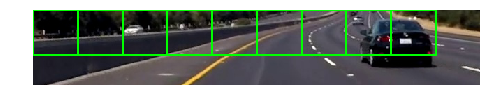

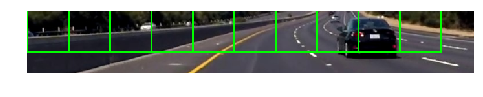

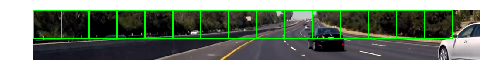

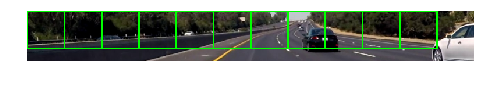

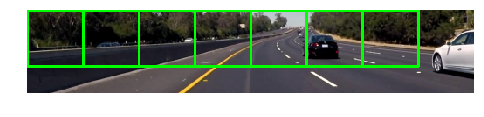

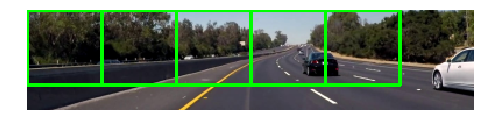

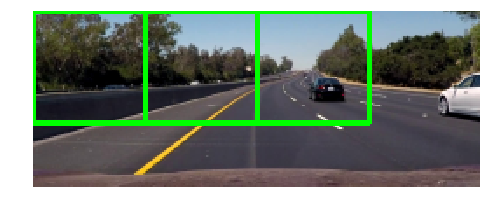

In [37]:


    
def make_sub_image(img, x_range, y_range, resize_factor):   
    size_x = img.shape[1]
    size_y = img.shape[0]
    return cv2.resize(img[int(y_range[0]*size_y):int(y_range[1]*size_y), 
                          int(x_range[0]*size_x):int(x_range[1]*size_x)],                           
                      None, fx=resize_factor, fy=resize_factor, interpolation=cv2.INTER_AREA)
    

img = cv2.imread('./export.jpg')


def get_sub_images(img):    
    yield make_sub_image(img, (0.25, 0.75), (0.55, 0.7), 1.0)
    yield make_sub_image(img, (0.2, 0.8), (0.55, 0.7), 0.9) #
    yield make_sub_image(img, (0, 1), (0.5, 0.7), 0.8)
    yield make_sub_image(img, (0, 1), (0.5, 0.7), 0.6)
    yield make_sub_image(img, (0, 1), (0.47, 0.8), 0.4)
    yield make_sub_image(img, (0, 1), (0.4, 0.8), 0.3)
    yield make_sub_image(img, (0, 1), (0.3, 1), 0.2) 

def plot_sub_images(img):
    for sub_img in get_sub_images(img):
        img_patches = get_patches(sub_img, 8)[0]        
        plot_image(draw_patches(sub_img, img_patches))

#img_sub = get_sub_image(img, (0.25, 0.75), (0.55, 0.7), 1.0)
#img_sub = get_sub_image(img, (0.2, 0.8), (0.5, 0.7), 0.8)
#img_sub = get_sub_image(img, (0.1, 0.9), (0.5, 0.8), 0.6)
#img_sub = get_sub_image(img, (0, 1), (0.5, 0.8), 0.4)
#img_sub = get_sub_image(img, (0, 1), (0.5, 0.8), 0.3) # smaller stride, e.g. 2
#img_sub = get_sub_image(img, (0, 1), (0.35, 1), 0.2) # smaller stride, e.g. 2

plot_sub_images(img)



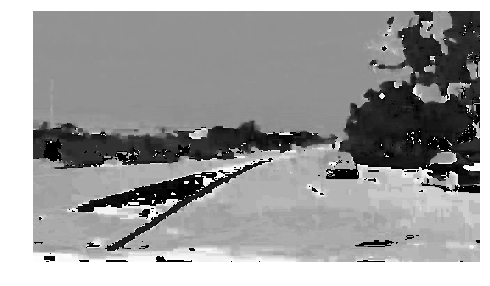

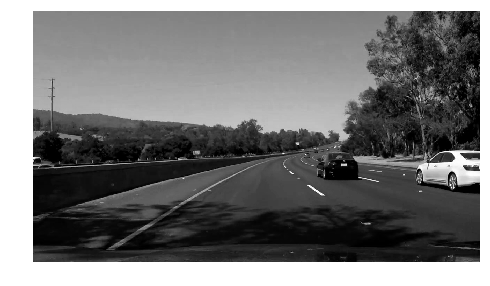

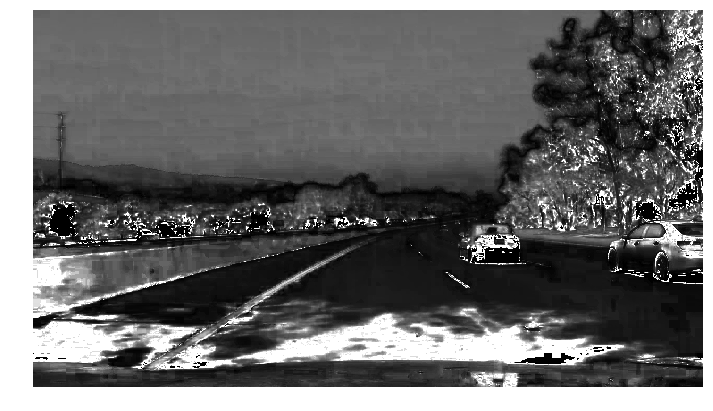

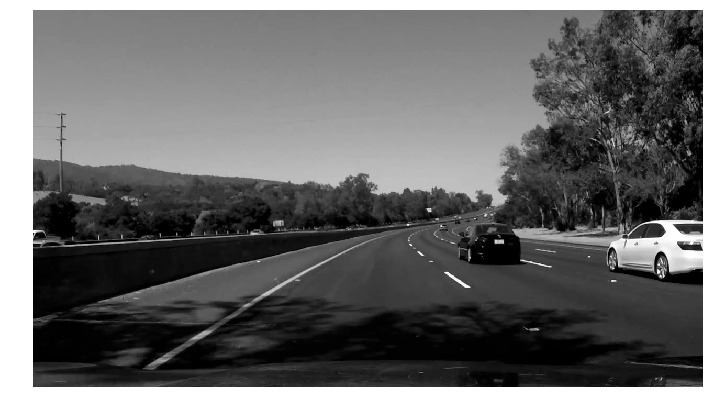

In [182]:
img = cv2.imread('./export.jpg')

img_conv = cv2.cvtColor(img, cv2.COLOR_BGR2HLS) 

plot_image(img_conv[:,:,0]) # not much usage
plot_image(img_conv[:,:,1])
plot_image(img_conv[:,:,2], size=(12,8))

plot_image(convert_to_gray(img),  size=(12,8))